<a href="https://colab.research.google.com/github/rubythalib33/Sekolah-AI-Indonesia/blob/main/Course%201.%20Pytorch%2BLightning%20Coureses%20Level%201/1_7_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.7 Transformer

In [1]:
# Source Tutorial https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
# I literally just copy paste from the source because it's just so amazing south out to UvA Deep Learning course


In [2]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Global seed set to 42


Device: cuda:0


In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Scaled Dot Product Attention
- Query: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.

- Keys: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.

- Values: For each input element, we also have a value vector. This feature vector is the one we want to average over.

In [4]:
def scaled_dot_product(q,k,v, mask=None):
  d_k = q.size()[-1]
  attn_logits = torch.matmul(q, k.transpose(-2, -1))
  attn_logits = attn_logits / math.sqrt(d_k)
  if mask is not None:
    attn_logits = attn_logits.masked_fill(mask==0, -9e15)
  attention = F.softmax(attn_logits, dim=-1)
  values = torch.matmul(attention,v)

  return values, attention

In [5]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q,k,v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


## Multi-Head Attention

In [6]:
class MultiheadAttention(nn.Module):

  def __init__(self, input_dim, embed_dim, num_heads):
    super().__init__()
    assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim//num_heads

    self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
    self.o_proj = nn.Linear(embed_dim, embed_dim)

    self._reset_parameters()
  
  def _reset_parameters(self):
    nn.init.xavier_uniform_(self.qkv_proj.weight)
    self.qkv_proj.bias.data.fill_(0)
    nn.init.xavier_uniform_(self.o_proj.weight)
    self.o_proj.bias.data.fill_(0)
  
  def forward(self, x, mask=None, return_attention=False):
    batch_size, seq_length, embed_dim = x.size()
    qkv = self.qkv_proj(x)

    #seperate QKV
    qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
    qkv = qkv.permute(0,2,1,3)
    q,k,v = qkv.chunk(3, dim=-1)

    #determine value outputs
    values, attention = scaled_dot_product(q,k,v, mask=mask)
    values = values.permute(0,2,1,3)
    values = values.reshape(batch_size, seq_length, embed_dim)

    o = self.o_proj(values)

    if return_attention:
      return o, attention
    else:
      return o


## Transformer
transformer_architecture.svg

### Encoder

In [7]:
class EncoderBlock(nn.Module):
  def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
    """
        Inputs:
        input_dim - Dimensionality of the input
        num_heads - Number of heads to use in the attention block
        dim_feedforward - Dimensionality of the hidden layer in the MLP
        dropout - Dropout probability to use in the dropout layers
    """
    super().__init__()
    #attention layer
    self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
    # Two layer MLP
    self.linear_net = nn.Sequential(
        nn.Linear(input_dim, dim_feedforward),
        nn.Dropout(dropout),
        nn.ReLU(inplace=True),
        nn.Linear(dim_feedforward, input_dim)
    )

    
    #Layers to apply in between the main layers
    self.norm1 = nn.LayerNorm(input_dim)
    self.norm2 = nn.LayerNorm(input_dim)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x, mask=None):
    attn_out = self.self_attn(x, mask=mask)
    x = x + self.dropout(attn_out)
    x = self.norm1(x)

    linear_out = self.linear_net(x)
    x = x + self.dropout(linear_out)
    x = self.norm2(x)

    return x

In [8]:
class TransformerEncoder(nn.Module):
  def __init__(self, num_layers, **block_args):
    super().__init__()
    self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])
  
  def forward(self, x, mask=None):
    for l in self.layers:
        x = l(x, mask=mask)
    return x
  
  def get_attention_maps(self, x, mask=None):
    attention_maps = []
    for l in self.layers:
        _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
        attention_maps.append(attn_map)
        x = l(x)
    return attention_maps

In [9]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super().__init__()
    
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float()* (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
    # Used for tensors that need to be on the same device as the module.
    # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
    self.register_buffer('pe', pe, persistent=False)
  def forward(self, x):
    x = x + self.pe[:, :x.size(1)]
    return x


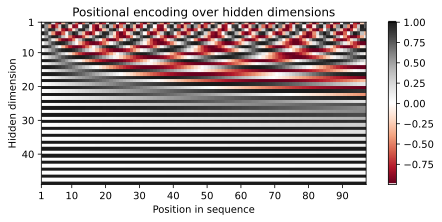

In [10]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions 1, 2, 3 and 4 

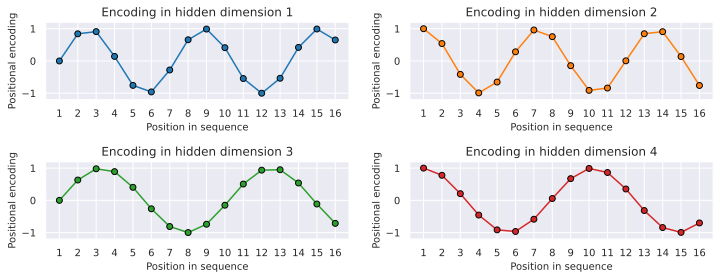

In [11]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

## Learning rate warm-up
One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing. Take for instance the following plot by Liu et al. (2019) comparing Adam-vanilla (i.e. Adam without warm-up) vs Adam with a warm-up:
<br>
warmup_loss_plot.svg
<br>
Clearly, the warm-up is a crucial hyperparameter in the Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like RAdam have been shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using Pre-Layer Normalization (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques (Adaptive Normalization, Power Normalization).

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used an exponential decay scheduler with a warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs.

In [12]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
  def __init__(self, optimizer, warmup, max_iters):
    self.warmup = warmup
    self.max_num_iters = max_iters
    super().__init__(optimizer)

  def get_lr(self):
    lr_factor = self.get_lr_factor(epoch=self.last_epoch)
    return [base_lr * lr_factor for base_lr in self.base_lrs]
  
  def get_lr_factor(self, epoch):
    lr_factor = 0.5 * (1+np.cos(np.pi * epoch/ self.max_num_iters))
    if epoch <= self.warmup:
        lr_factor *= epoch * 1.0 / self.warmup
    return lr_factor

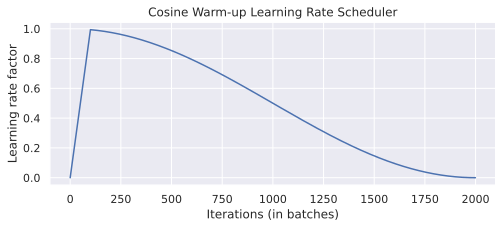

In [13]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()


In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library huggingface.



## Pytorch Lightning Module

In [15]:
class TransformerPredictor(pl.LightningModule):
  def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
    """
    Inputs:
        input_dim - Hidden dimensionality of the input
        model_dim - Hidden dimensionality to use inside the Transformer
        num_classes - Number of classes to predict per sequence element
        num_heads - Number of heads to use in the Multi-Head Attention blocks
        num_layers - Number of encoder blocks to use.
        lr - Learning rate in the optimizer
        warmup - Number of warmup steps. Usually between 50 and 500
        max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
        dropout - Dropout to apply inside the model
        input_dropout - Dropout to apply on the input features
    """
    super().__init__()
    self.save_hyperparameters()
    self._create_model()

  def _create_model(self):
    self.input_net = nn.Sequential(
        nn.Dropout(self.hparams.input_dropout),
        nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
    )
    self.positional_encoding= PositionalEncoding(d_model=self.hparams.model_dim)
    # Transformer
    self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                          input_dim=self.hparams.model_dim,
                                          dim_feedforward=2*self.hparams.model_dim,
                                          num_heads=self.hparams.num_heads,
                                          dropout=self.hparams.dropout)
    # Output classifier per sequence lement
    self.output_net = nn.Sequential(
        nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
        nn.LayerNorm(self.hparams.model_dim),
        nn.ReLU(inplace=True),
        nn.Dropout(self.hparams.dropout),
        nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
    )
  
  def forward(self, x, mask=None, add_positional_encoding=True):
    """
    Inputs:
        x - Input features of shape [Batch, SeqLen, input_dim]
        mask - Mask to apply on the attention outputs (optional)
        add_positional_encoding - If True, we add the positional encoding to the input.
                                  Might not be desired for some tasks.
    """
    x = self.input_net(x)
    if add_positional_encoding:
      x = self.positional_encoding(x)
    x = self.transformer(x, mask=mask)
    x = self.output_net(x)
    return x
  @torch.no_grad()
  def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
    """
    Function for extracting the attention matrices of the whole Transformer for a single batch.
    Input arguments same as the forward pass.
    """
    x = self.input_net(x)
    if add_positional_encoding:
      x = self.positional_encoding(x)
    attention_maps = self.transformer.get_attention_maps(x, mask=mask)
    return attention_maps
  
  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

    # Apply lr scheduler per step
    lr_scheduler = CosineWarmupScheduler(optimizer,
                                          warmup=self.hparams.warmup,
                                          max_iters=self.hparams.max_iters)
    return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

  def training_step(self, batch, batch_idx):
    raise NotImplementedError

  def validation_step(self, batch, batch_idx):
    raise NotImplementedError

  def test_step(self, batch, batch_idx):
    raise NotImplementedError

## Experiments

### Sequence to Sequence

We create an arbitrary number of random sequences of numbers between 0 and num_categories-1. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders below.

In [16]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [17]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [18]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token. We use the standard Cross-Entropy loss to perform this. Every number is represented as a one-hot vector. Remember that representing the categories as single scalars decreases the expressiveness of the model extremely as  and  are not closer related than  and  in our example. An alternative to a one-hot vector is using a learned embedding vector as it is provided by the PyTorch module nn.Embedding. However, using a one-hot vector with an additional linear layer as in our case has the same effect as an embedding layer (self.input_net maps one-hot vector to a dense vector, where each row of the weight matrix represents the embedding for a specific category).

In [19]:
class ReversePredictor(TransformerPredictor):

  def _calculate_loss(self, batch, mode="train"):
    # Fetch data and transform categories to one-hot vectors
    inp_data, labels = batch
    inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

    # Perform prediction and calculate loss and accuracy
    preds = self.forward(inp_data, add_positional_encoding=True)
    loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
    acc = (preds.argmax(dim=-1) == labels).float().mean()

    # Logging
    self.log(f"{mode}_loss", loss)
    self.log(f"{mode}_acc", acc)
    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, _ = self._calculate_loss(batch, mode="train")
    return loss

  def validation_step(self, batch, batch_idx):
    _ = self._calculate_loss(batch, mode="val")

  def test_step(self, batch, batch_idx):
    _ = self._calculate_loss(batch, mode="test")

In [20]:
def train_reverse(**kwargs):
  # Create a PyTorch Lightning trainer with the generation callback
  root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
  os.makedirs(root_dir, exist_ok=True)
  trainer = pl.Trainer(default_root_dir=root_dir,
                        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                        gpus=1 if str(device).startswith("cuda") else 0,
                        max_epochs=10,
                        gradient_clip_val=5,
                        progress_bar_refresh_rate=1)
  trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

  # Check whether pretrained model exists. If yes, load it and skip training
  pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
  if os.path.isfile(pretrained_filename):
      print("Found pretrained model, loading...")
      model = ReversePredictor.load_from_checkpoint(pretrained_filename)
  else:
      model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
      trainer.fit(model, train_loader, val_loader)

  # Test best model on validation and test set
  val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
  test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
  result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

  model = model.to(device)
  return model, result

In [21]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RAN

Found pretrained model, loading...


Missing logger folder: ../saved_models/tutorial6/ReverseTask/lightning_logs


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [22]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


As we would have expected, the Transformer can correctly solve the task. However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input? Let’s try to visualize it below.

In [23]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [24]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

In [26]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

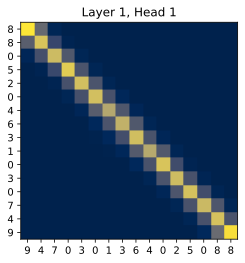

In [27]:
plot_attention_maps(data_input, attention_maps, idx=0)

## Set Anomaly Detections
Transformers offer the perfect architecture for this as the Multi-Head Attention is permutation-equivariant, and thus, outputs the same values no matter in what order we enter the inputs (inputs and outputs are permuted equally). The task we are looking at for sets is Set Anomaly Detection which means that we try to find the element(s) in a set that does not fit the others. In the research community, the common application of anomaly detection is performed on a set of images, where N-1 images belong to the same category/have the same high-level features while one belongs to another category. Note that category does not necessarily have to relate to a class in a standard classification problem, but could be the combination of multiple features. For instance, on a face dataset, this could be people with glasses, male, beard, etc. An example of distinguishing different animals can be seen below. The first four images show foxes, while the last represents a different animal. We want to recognize that the last image shows a different animal, but it is not relevant which class of animal it is.
![image](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/cifar100_example_anomaly.png)

In this tutorial, we will use the CIFAR100 dataset. CIFAR100 has 600 images for 100 classes each with a resolution of 32x32, similar to CIFAR10. The larger amount of classes requires the model to attend to specific features in the images instead of coarse features as in CIFAR10, therefore making the task harder. We will show the model a set of 9 images of one class, and 1 image from another class. The task is to find the image that is from a different class than the other images. Using the raw images directly as input to the Transformer is not a good idea, because it is not translation invariant as a CNN, and would need to learn to detect image features from high-dimensional input first of all. Instead, we will use a pre-trained ResNet34 model from the torchvision package to obtain high-level, low-dimensional features of the images. The ResNet model has been pre-trained on the ImageNet dataset which contains 1 million images of 1k classes and varying resolutions. However, during training and testing, the images are usually scaled to a resolution of 224x224, and hence we rescale our CIFAR images to this resolution as well. Below, we will load the dataset, and prepare the data for being processed by the ResNet model.


In [28]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


In [29]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial6/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [30]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [31]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [32]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [33]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()


    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets


    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices


    def __len__(self):
        return self.img_feats.shape[0]


    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [34]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


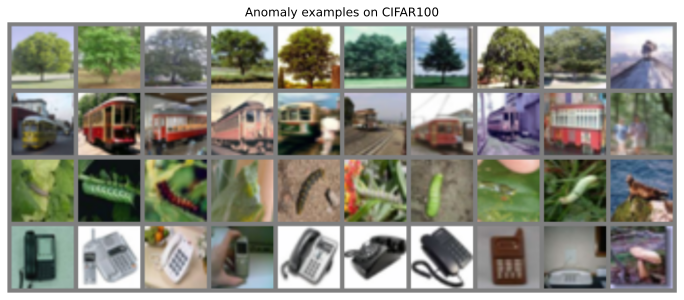

In [35]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

In [50]:
img, indices, label = next(iter(test_anom_loader))
print(img[0].shape)
print(label[0])
print(indices[0])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([10, 512])
tensor(9)
tensor([9427, 1683, 4931,  138, 8398, 1021, 8789, 4213, 4730,    0])


In [36]:
class AnomalyPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        preds = self.forward(img_sets, add_positional_encoding=False) # No positional encodings as it is a set, not a sequence!
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]
        loss = F.cross_entropy(preds, labels) # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [37]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=100,
                         gradient_clip_val=2,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs*len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=train_anom_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [38]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RAN

Found pretrained model, loading...


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [39]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 96.45%
Val accuracy:   95.92%
Test accuracy:  94.41%


In [40]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Preds
 [2.7691525e-05 1.8979941e-05 1.7386521e-05 2.7843131e-05 1.6143054e-05
 1.7020926e-05 5.7295008e-05 9.9977750e-01 2.1365258e-05 1.8681923e-05]
Permuted preds
 [2.7691525e-05 1.8979941e-05 1.7386488e-05 2.7843131e-05 1.6143054e-05
 1.7020926e-05 5.7295059e-05 9.9977750e-01 2.1365258e-05 1.8681923e-05]


In [41]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

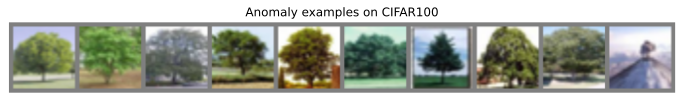

Prediction: 9


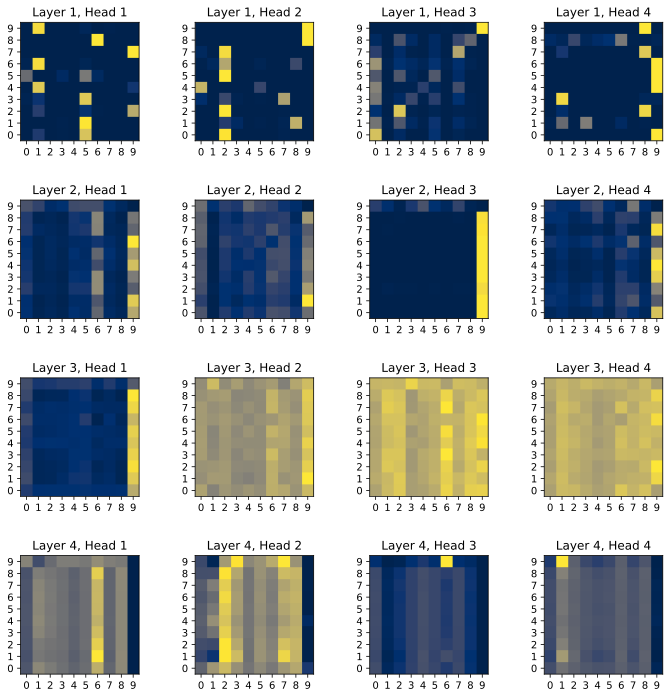

In [42]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

In [43]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

Indices with mistake: [49]


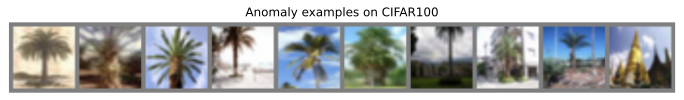

Prediction: 7


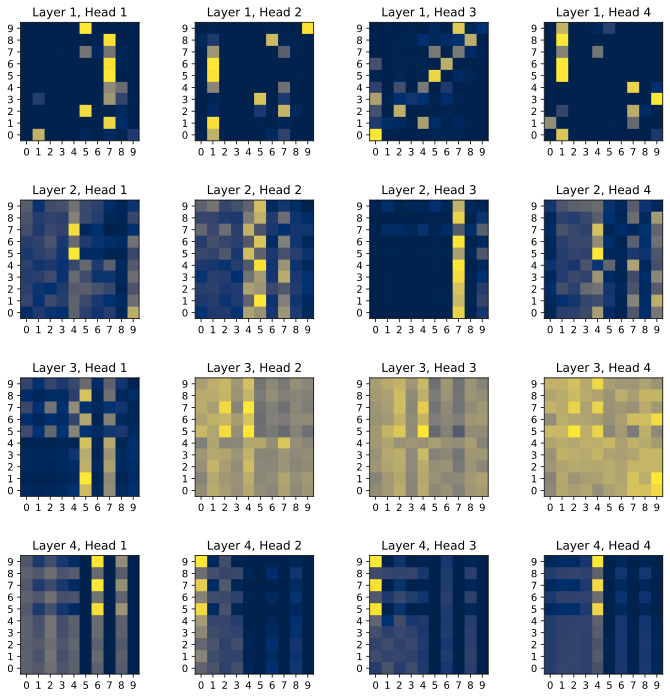

Probabilities:
Image 0: 0.07%
Image 1: 0.11%
Image 2: 0.07%
Image 3: 0.11%
Image 4: 0.17%
Image 5: 23.27%
Image 6: 0.16%
Image 7: 48.91%
Image 8: 0.10%
Image 9: 27.03%


In [44]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print(f"Image {i}: {100.0*p:4.2f}%")

## Conclusion
In this tutorial, we took a closer look at the Multi-Head Attention layer which uses a scaled dot product between queries and keys to find correlations and similarities between input elements. The Transformer architecture is based on the Multi-Head Attention layer and applies multiple of them in a ResNet-like block. The Transformer is a very important, recent architecture that can be applied to many tasks and datasets. Although it is best known for its success in NLP, there is so much more to it. We have seen its application on sequence-to-sequence tasks and set anomaly detection. Its property of being permutation-equivariant if we do not provide any positional encodings, allows it to generalize to many settings. Hence, it is important to know the architecture, but also its possible issues such as the gradient problem during the first iterations solved by learning rate warm-up. If you are interested in continuing with the study of the Transformer architecture, please have a look at the blog posts listed at the beginning of the tutorial notebook.